### Hadoop3.3 + Spark3.0 + IPython3.7 机器学习与大数据实战
## <center>流程式机器学习二元分类 >>> 基于 Spark ML Pipeline</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.12.23</center>  
  
<font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>   
  
<font color=blue><center>项目源代码、数据、自定义函数已上传GitHub：</center></font>   
    
<font color=blue><center>https://github.com/lotbear/Python-Financial-investment-strategy</center></font>

### 流程式机器学习  Spark ML Pipeline

ML Pipeline 的原理是，将机器学习的每一个阶段（如数据清洗、特征工程、模型训练、模型预测等）集合成一个固定的流程，方便不断重复调用。

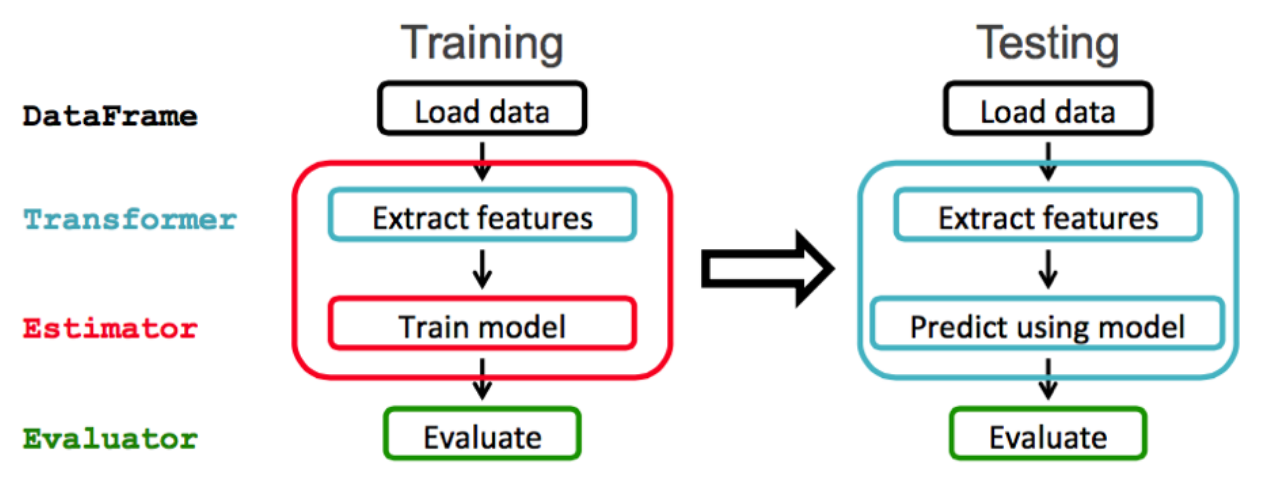

本例中，我们将 Pipeline 划分为 4 个阶段，前 3 个阶段是数据处理，第 4 个阶段为 模型拟合：   

1》 StringIndexer : 将字符串型 类别数据，转换为数值型数据；   

2》 OneHotEncoder : 将上一步转换的类别数字，进行 0 1 独热编码；   

3》 VectorAssembler : 将所有特征向量整合在一起；   

4》 DesionTreeClassifier : 用决策树模型进行训练。

### 二元分类项目：网页实效性 

#### <font color=blue>>>> 通过算法建模，将网页实效性分为 ephemeral（暂时型）和 evergreen（长青型）两类。</font>       

数据基本情况：   

该项目提供 2 个数据文件：train.tsv（训练集）  ;  test.tsv （测试集）      

训练集数据，数据总量：7395 个网页数据，变量数：26个，有分类标签（ label: ephemeral=0； evergreen=1 ）  

测试集数据，数据总量：3171 个网页数据，变量数：26个，无分类标签，需要模型预测出分类标签 

#### 拿到数据后，我们首先要 “ 分析问题 ”：   

网页内容的实效性短的（ephemeral），比如 新闻热点 / 股市消息 / 季节性话题等；内容实效性长的（evergreen），比如 理财观念 / 读书笔记等。   

从算法工程角度，分析每个网页页面的关键词，并进行实效性建模是一种方案，但面对庞大的网页数据库，爬取每个页面的关键词再进行模型拟合，从实际应用角度，并不是一种讨巧的解决方案。   

#### <font color=blue>>>> 因此，我们设计的解决方案是：利用网页的特征属性（非页面内容）进行实效性判断</font>       
   
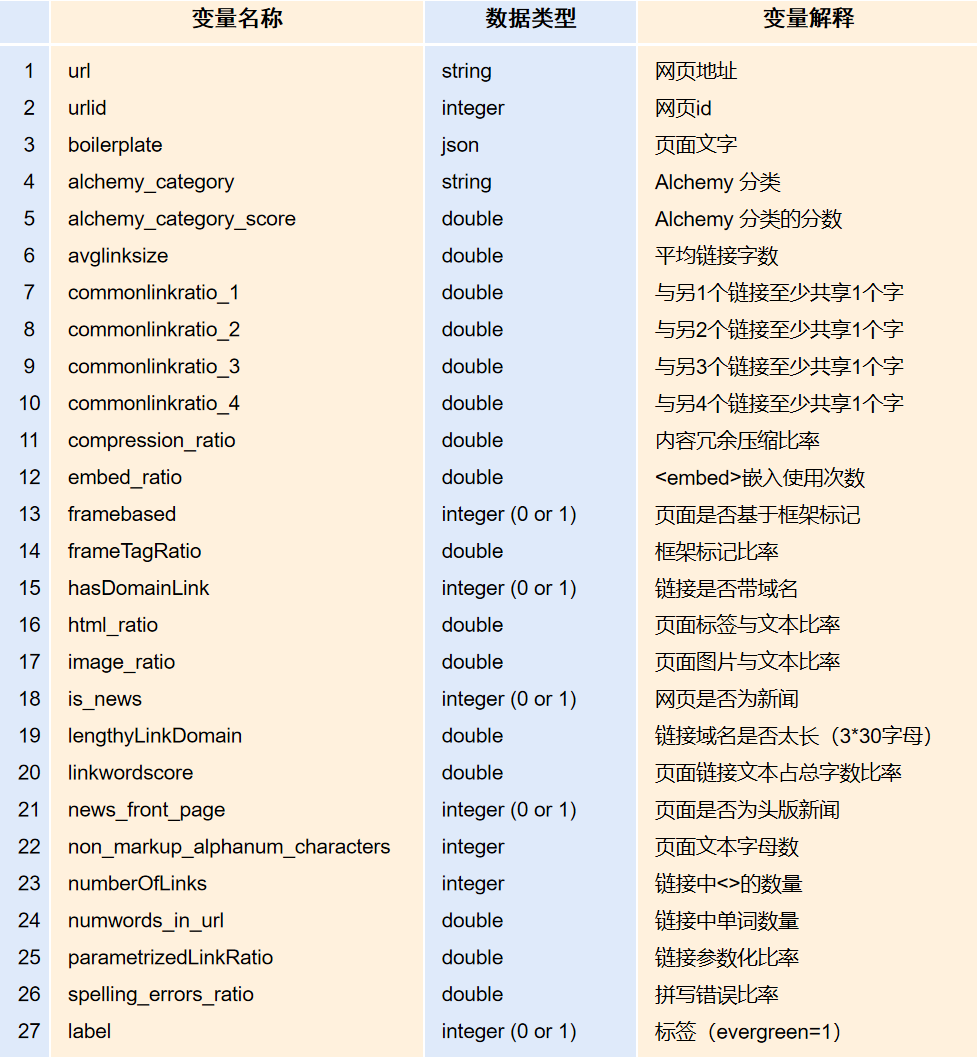

### >>> 算法实战     

### 第一步：数据上传 Hadoop-HDFS 分布式平台后，用 Saprk 命令读取 / 查看 / 清洗。

In [1]:
# 查看 Spark 的运行模式，本次算法基于 Hadoop-yarn 模式
# 实现 4 台虚拟机同步进行的分布式运算
print('查看 Spark 的运行模式：',str(sc.master))

查看 Spark 的运行模式： yarn


In [2]:
# 设置全局数据集的路径
# 若 sc.master 查看显示的运行模式为 "local",则使用本地数据集
# 若 sc.master 查看显示的运行模式为其他，如 "yarn"，"spark://master:7077"(Standalone模式)
# 则选择 HDFS 上的数据集
global Path    
if sc.master[0:5]=="local" :
   Path="/home/lotbear/Big-Data/web_evergreen/"
else:   
   Path="hdfs://master:9000/user/lotbear/data/web_evergreen/"

Spark ML 机器学习 API 处理的数据格式为 DataFrame    

因此选择用 sqlContext.read 导入文件，并创建 row_df 为 DataFrame 格式

In [3]:
row_df = sqlContext.read.format("csv") \
     .option("header", "true") \
     .option("delimiter", "\t") \
     .load(Path+"train.tsv")
print('训练集数据总量：',row_df.count())

训练集数据总量： 7395


In [4]:
# 查看数据的 Schema(字段名 + 数据类型)
row_df.printSchema()

root
 |-- url: string (nullable = true)
 |-- urlid: string (nullable = true)
 |-- boilerplate: string (nullable = true)
 |-- alchemy_category: string (nullable = true)
 |-- alchemy_category_score: string (nullable = true)
 |-- avglinksize: string (nullable = true)
 |-- commonlinkratio_1: string (nullable = true)
 |-- commonlinkratio_2: string (nullable = true)
 |-- commonlinkratio_3: string (nullable = true)
 |-- commonlinkratio_4: string (nullable = true)
 |-- compression_ratio: string (nullable = true)
 |-- embed_ratio: string (nullable = true)
 |-- framebased: string (nullable = true)
 |-- frameTagRatio: string (nullable = true)
 |-- hasDomainLink: string (nullable = true)
 |-- html_ratio: string (nullable = true)
 |-- image_ratio: string (nullable = true)
 |-- is_news: string (nullable = true)
 |-- lengthyLinkDomain: string (nullable = true)
 |-- linkwordscore: string (nullable = true)
 |-- news_front_page: string (nullable = true)
 |-- non_markup_alphanum_characters: string (nulla

In [5]:
# 选择部分字段，进行查看
row_df.select('url','alchemy_category','alchemy_category_score','is_news','label').show(10)

+--------------------+------------------+----------------------+-------+-----+
|                 url|  alchemy_category|alchemy_category_score|is_news|label|
+--------------------+------------------+----------------------+-------+-----+
|http://www.bloomb...|          business|              0.789131|      1|    0|
|http://www.popsci...|        recreation|              0.574147|      1|    1|
|http://www.menshe...|            health|              0.996526|      1|    1|
|http://www.dumbli...|            health|              0.801248|      1|    1|
|http://bleacherre...|            sports|              0.719157|      1|    0|
|http://www.conven...|                 ?|                     ?|      ?|    0|
|http://gofashionl...|arts_entertainment|               0.22111|      1|    1|
|http://www.inside...|                 ?|                     ?|      ?|    0|
|http://www.valetm...|                 ?|                     ?|      1|    1|
|http://www.howswe...|                 ?|           

In [6]:
# 编写 UDF 用户自定义函数，将 ？ 数据改为 0
from pyspark.sql.functions import udf
def replace_question(x):
    return ("0" if x=="?" else x)
replace_question= udf(replace_question)

In [7]:
from pyspark.sql.functions import col  
import pyspark.sql.types 
# 将第 4 个字段至最后一个字段的数据类型改为 double, 其余字段类型为 feature
df= row_df.select(['url','alchemy_category' ]+
                  [replace_question(col(column)).cast("double").alias(column)  
                  for column in row_df.columns[4:] ] )

In [8]:
# 将训练集数据按 7：3 分为 train_df，test_df 两个数据集
train_df, test_df = df.randomSplit([0.7, 0.3])
train_df.cache()
test_df.cache()

DataFrame[url: string, alchemy_category: string, alchemy_category_score: double, avglinksize: double, commonlinkratio_1: double, commonlinkratio_2: double, commonlinkratio_3: double, commonlinkratio_4: double, compression_ratio: double, embed_ratio: double, framebased: double, frameTagRatio: double, hasDomainLink: double, html_ratio: double, image_ratio: double, is_news: double, lengthyLinkDomain: double, linkwordscore: double, news_front_page: double, non_markup_alphanum_characters: double, numberOfLinks: double, numwords_in_url: double, parametrizedLinkRatio: double, spelling_errors_ratio: double, label: double]

### 第二步：使用 ML Pipeline 流程组件，进行阶段模块设计

导入相关工具包 ：   

<font color=red>特征工程：</font> <font color=blue>StringIndexer --> OneHotEncoder --> VectorAssembler</font>   

<font color=red>分类模型：</font> <font color=blue>DecisionTreeClassifier</font>

In [9]:
from pyspark.ml.feature import  StringIndexer, OneHotEncoder,VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

In [10]:
# 创建 字符串分类数据 的索引变量 alchemy_category_Index 
categoryIndexer = StringIndexer(inputCol='alchemy_category', 
                                outputCol="alchemy_category_Index")
df1=categoryIndexer.fit(df)

In [11]:
for i in range(0,len(df1.labels)):
    print(str(i)+':'+df1.labels[i]) 

0:?
1:recreation
2:arts_entertainment
3:business
4:health
5:sports
6:culture_politics
7:computer_internet
8:science_technology
9:gaming
10:religion
11:law_crime
12:unknown
13:weather


In [12]:
df1=df1.transform(df)
# alchemy_category_Index 类型索引变量被加入到数据集最后一列
df1.columns

['url',
 'alchemy_category',
 'alchemy_category_score',
 'avglinksize',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'embed_ratio',
 'framebased',
 'frameTagRatio',
 'hasDomainLink',
 'html_ratio',
 'image_ratio',
 'is_news',
 'lengthyLinkDomain',
 'linkwordscore',
 'news_front_page',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio',
 'label',
 'alchemy_category_Index']

In [13]:
df1.select("alchemy_category","alchemy_category_Index").show(10)

+------------------+----------------------+
|  alchemy_category|alchemy_category_Index|
+------------------+----------------------+
|          business|                   3.0|
|        recreation|                   1.0|
|            health|                   4.0|
|            health|                   4.0|
|            sports|                   5.0|
|                 ?|                   0.0|
|arts_entertainment|                   2.0|
|                 ?|                   0.0|
|                 ?|                   0.0|
|                 ?|                   0.0|
+------------------+----------------------+
only showing top 10 rows



In [14]:
# 对类别索引数据进行 OneHotEncoder 编码
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(dropLast=False,
                            inputCol='alchemy_category_Index', 
                            outputCol="alchemy_category_IndexVec")

# OneHotEncoder 对类别数据进行编码后，新增字段 'alchemy_category_IndexVec'
df2=encoder.fit(df1)
df2=df2.transform(df1)
df2.columns

['url',
 'alchemy_category',
 'alchemy_category_score',
 'avglinksize',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'embed_ratio',
 'framebased',
 'frameTagRatio',
 'hasDomainLink',
 'html_ratio',
 'image_ratio',
 'is_news',
 'lengthyLinkDomain',
 'linkwordscore',
 'news_front_page',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio',
 'label',
 'alchemy_category_Index',
 'alchemy_category_IndexVec']

alchemy_category_IndexVec 变量值举例：   

(14,[3],[1.0]) 意为 One-hot 编码后，类别分为 14 个字段，该类别是第 3 个字段为 1，其余字段为 0    

即：00100000000000

In [15]:
df2.select("alchemy_category","alchemy_category_Index",
                    "alchemy_category_IndexVec").show(10)

+------------------+----------------------+-------------------------+
|  alchemy_category|alchemy_category_Index|alchemy_category_IndexVec|
+------------------+----------------------+-------------------------+
|          business|                   3.0|           (14,[3],[1.0])|
|        recreation|                   1.0|           (14,[1],[1.0])|
|            health|                   4.0|           (14,[4],[1.0])|
|            health|                   4.0|           (14,[4],[1.0])|
|            sports|                   5.0|           (14,[5],[1.0])|
|                 ?|                   0.0|           (14,[0],[1.0])|
|arts_entertainment|                   2.0|           (14,[2],[1.0])|
|                 ?|                   0.0|           (14,[0],[1.0])|
|                 ?|                   0.0|           (14,[0],[1.0])|
|                 ?|                   0.0|           (14,[0],[1.0])|
+------------------+----------------------+-------------------------+
only showing top 10 

In [16]:
# 将所有特征向量进行汇总
from pyspark.ml.feature import  VectorAssembler
assemblerInputs =['alchemy_category_IndexVec']  +  row_df.columns[4:-1]
assemblerInputs

['alchemy_category_IndexVec',
 'alchemy_category_score',
 'avglinksize',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'embed_ratio',
 'framebased',
 'frameTagRatio',
 'hasDomainLink',
 'html_ratio',
 'image_ratio',
 'is_news',
 'lengthyLinkDomain',
 'linkwordscore',
 'news_front_page',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio']

In [17]:
assembler = VectorAssembler(inputCols=assemblerInputs,  
                            outputCol="features")
df3=assembler.transform(df2)
df3.columns

['url',
 'alchemy_category',
 'alchemy_category_score',
 'avglinksize',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'embed_ratio',
 'framebased',
 'frameTagRatio',
 'hasDomainLink',
 'html_ratio',
 'image_ratio',
 'is_news',
 'lengthyLinkDomain',
 'linkwordscore',
 'news_front_page',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio',
 'label',
 'alchemy_category_Index',
 'alchemy_category_IndexVec',
 'features']

所有汇总的特征向量，共计 36 个

In [18]:
df3.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|(36,[3,14,15,16,1...|
|(36,[1,14,15,16,1...|
|(36,[4,14,15,16,1...|
|(36,[4,14,15,16,1...|
|(36,[5,14,15,16,1...|
+--------------------+
only showing top 5 rows



显示一条样本数据的 全部特征向量值   

举例 --> 其中 " 3: 1.0 " 表示第 3 个特征向量值为 1.0

In [19]:
df3.select('features').take(1)

[Row(features=SparseVector(36, {3: 1.0, 14: 0.7891, 15: 2.0556, 16: 0.6765, 17: 0.2059, 18: 0.0471, 19: 0.0235, 20: 0.4438, 23: 0.0908, 25: 0.2458, 26: 0.0039, 27: 1.0, 28: 1.0, 29: 24.0, 31: 5424.0, 32: 170.0, 33: 8.0, 34: 0.1529, 35: 0.0791}))]

用决策树模型训练数据

In [20]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",
                            impurity="gini",maxDepth=10, maxBins=14)
dt_model=dt.fit(df3)
dt_model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_bf1b5a09eb40, depth=10, numNodes=653, numClasses=2, numFeatures=36

In [21]:
df4=dt_model.transform(df3)

### 第三步：将上述所有设计的数据处理模块，导入 Pipeline 管线

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer, OneHotEncoder,VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

In [23]:
stringIndexer = StringIndexer(inputCol='alchemy_category', outputCol="alchemy_category_Index")

encoder = OneHotEncoder(dropLast=False,inputCol='alchemy_category_Index',outputCol="alchemy_category_IndexVec")

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",impurity="gini",
                                                   maxDepth=10, maxBins=14)

pipeline = Pipeline(stages=[stringIndexer,encoder ,assembler,dt ])

pipeline.getStages()

[StringIndexer_d2dd720fe32d,
 OneHotEncoder_0e2caf084ec1,
 VectorAssembler_f3c816df9cf1,
 DecisionTreeClassifier_666982787f23]

### >>> 使用 Pipeline 进行训练

In [24]:
pipelineModel = pipeline.fit(train_df)
pipelineModel.stages[3]

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_666982787f23, depth=10, numNodes=453, numClasses=2, numFeatures=36

ML Pipline 的阶段序号为：0~3  

因此，决策树建模阶段为 stage[3]，用 toDebugString[:1000]) 查看训练好的模型的前 1000 字节的规则描述

In [25]:
print(pipelineModel.stages[3].toDebugString[:1000])

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_666982787f23, depth=10, numNodes=453, numClasses=2, numFeatures=36
  If (feature 31 <= 1320.5)
   If (feature 4 in {1.0})
    If (feature 20 <= 0.6186003845000001)
     If (feature 20 <= 0.461496237)
      If (feature 15 <= 1.830348577)
       Predict: 1.0
      Else (feature 15 > 1.830348577)
       Predict: 0.0
     Else (feature 20 > 0.461496237)
      Predict: 1.0
    Else (feature 20 > 0.6186003845000001)
     If (feature 23 <= 0.07855862899999999)
      If (feature 29 <= 65.5)
       Predict: 1.0
      Else (feature 29 > 65.5)
       If (feature 14 <= 0.540559)
        Predict: 0.0
       Else (feature 14 > 0.540559)
        If (feature 15 <= 2.531057099)
         Predict: 1.0
        Else (feature 15 > 2.531057099)
         Predict: 0.0
     Else (feature 23 > 0.07855862899999999)
      If (feature 32 <= 51.5)
       Predict: 0.0
      Else (feature 32 > 51.5)
       Predict: 1.0
   Else (feature 4 not in {1.0})
    If 

### >>> 使用 Pipeline 进行预测

In [26]:
predicted=pipelineModel.transform(test_df)
predicted.columns

['url',
 'alchemy_category',
 'alchemy_category_score',
 'avglinksize',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'embed_ratio',
 'framebased',
 'frameTagRatio',
 'hasDomainLink',
 'html_ratio',
 'image_ratio',
 'is_news',
 'lengthyLinkDomain',
 'linkwordscore',
 'news_front_page',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio',
 'label',
 'alchemy_category_Index',
 'alchemy_category_IndexVec',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [27]:
predicted.select('url','features','rawprediction','probability','label','prediction').show(10)

+--------------------+--------------------+-------------+--------------------+-----+----------+
|                 url|            features|rawprediction|         probability|label|prediction|
+--------------------+--------------------+-------------+--------------------+-----+----------+
|http://1000awesom...|(36,[1,14,15,16,1...|    [9.0,0.0]|           [1.0,0.0]|  1.0|       0.0|
|http://100miledie...|(36,[0,15,20,23,2...|    [3.0,1.0]|         [0.75,0.25]|  0.0|       0.0|
|http://17andbakin...|(36,[3,14,15,16,1...| [24.0,225.0]|[0.09638554216867...|  1.0|       1.0|
|http://2oddities....|(36,[7,14,15,16,1...| [160.0,44.0]|[0.78431372549019...|  1.0|       0.0|
|http://30aeats.co...|(36,[0,15,16,17,1...| [33.0,174.0]|[0.15942028985507...|  1.0|       1.0|
|http://6jokes.com...|(36,[3,14,15,16,1...| [160.0,44.0]|[0.78431372549019...|  0.0|       0.0|
|http://98smile.co...|(36,[4,14,15,16,2...|   [10.0,0.0]|           [1.0,0.0]|  1.0|       0.0|
|http://9gag.com/g...|(36,[0,15,16,17,1.

查看测试样本预测结果为 ephemeral（暂时型）= 0 ；evergreen（长青型）= 1 分别的概率 probability  

以及最终判断的标签结果 prediction

In [28]:
predicted.select('probability','prediction') .take(10)

[Row(probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(probability=DenseVector([0.75, 0.25]), prediction=0.0),
 Row(probability=DenseVector([0.0964, 0.9036]), prediction=1.0),
 Row(probability=DenseVector([0.7843, 0.2157]), prediction=0.0),
 Row(probability=DenseVector([0.1594, 0.8406]), prediction=1.0),
 Row(probability=DenseVector([0.7843, 0.2157]), prediction=0.0),
 Row(probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(probability=DenseVector([0.7, 0.3]), prediction=0.0),
 Row(probability=DenseVector([0.7, 0.3]), prediction=0.0),
 Row(probability=DenseVector([0.7, 0.3]), prediction=0.0)]

### >>> 评估模型的准确率

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
                              rawPredictionCol="rawPrediction",
                              labelCol="label",  
                              metricName="areaUnderROC"  )
predictions =pipelineModel.transform(test_df)
auc= evaluator.evaluate(predictions)
print('模型 AUC 指标：',auc)

模型 AUC 指标： 0.6609052009589139


### >>> 使用 TrainValidation 进行模型评估，寻找最优参数 

先用网格搜素方式 ParamGridBuilder 对模型中的多个参数进行赋值    

再用 TrainValidationSplit 对各个参数组合得出的指标 AUC 进行排序，寻找最优参数指标

In [30]:
from pyspark.ml.tuning import ParamGridBuilder,TrainValidationSplit
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid = ParamGridBuilder()\
  .addGrid(dt.impurity, [ "gini","entropy"])\
  .addGrid(dt.maxDepth, [ 5,10,15])\
  .addGrid(dt.maxBins, [10, 15,20])\
  .build()

In [31]:
tvs = TrainValidationSplit(estimator=dt,evaluator=evaluator,
                  estimatorParamMaps=paramGrid,trainRatio=0.8)

tvs_pipeline = Pipeline(stages=[stringIndexer,encoder ,assembler, tvs])
tvs_pipelineModel =tvs_pipeline.fit(train_df)
bestModel=tvs_pipelineModel.stages[3].bestModel
bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3f4f96aed510, depth=15, numNodes=1491, numClasses=2, numFeatures=36

In [32]:
print(bestModel.toDebugString[:500])

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3f4f96aed510, depth=15, numNodes=1491, numClasses=2, numFeatures=36
  If (feature 31 <= 1215.5)
   If (feature 2 in {1.0})
    If (feature 35 <= 0.13289398400000002)
     If (feature 34 <= 0.0161945975)
      If (feature 16 <= 0.3498971195)
       If (feature 14 <= 0.7501800000000001)
        If (feature 35 <= 0.09165652899999999)
         Predict: 0.0
        Else (feature 35 > 0.09165652899999999)
         Predict: 1.0
       Else (fe


In [33]:
predictions = tvs_pipelineModel.transform(test_df)
auc= evaluator.evaluate(predictions)
print('模型 AUC 指标：',auc)

模型 AUC 指标： 0.6580452396836529


### >>> 使用 crossValidation 进行模型评估，寻找最优参数

进一步，可用 crossValidation 交叉验证法，对数据进行 K-Fold 训练及验证，得到更稳定的模型

In [34]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=dt, evaluator=evaluator, 
                    estimatorParamMaps=paramGrid, numFolds=3)

cv_pipeline = Pipeline(stages=[stringIndexer,encoder ,assembler, cv])
cv_pipelineModel = cv_pipeline.fit(train_df)
bestModel=cv_pipelineModel.stages[3].bestModel
bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3f4f96aed510, depth=15, numNodes=1451, numClasses=2, numFeatures=36

In [35]:
print(bestModel.toDebugString[:500])

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3f4f96aed510, depth=15, numNodes=1451, numClasses=2, numFeatures=36
  If (feature 31 <= 1566.5)
   If (feature 2 in {1.0})
    If (feature 34 <= 0.019834765)
     If (feature 15 <= 3.015639848)
      If (feature 29 <= 52.5)
       If (feature 18 <= 0.09355403400000001)
        If (feature 14 <= 0.7501800000000001)
         Predict: 0.0
        Else (feature 14 > 0.7501800000000001)
         If (feature 15 <= 1.7099788965)
          Pred


In [36]:
predictions = cv_pipelineModel.transform(test_df)
auc= evaluator.evaluate(predictions)
print('模型 AUC 指标：',auc)

模型 AUC 指标： 0.6421354323217168


### >>> 使用随机森林 RandomForestClassifier 进行数据训练

In [37]:
from pyspark.ml.classification import RandomForestClassifier

rf =RandomForestClassifier(labelCol="label", 
                           featuresCol="features",numTrees=10)

rfpipeline = Pipeline(stages=[stringIndexer,encoder ,assembler,rf ])

In [38]:
rfpipelineModel = rfpipeline.fit(train_df)
rfpredicted=rfpipelineModel.transform(test_df)
evaluator.evaluate(rfpredicted)

0.7316250949994256

In [39]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

paramGrid = ParamGridBuilder()\
  .addGrid(rf.impurity, [ "gini","entropy"])\
  .addGrid(rf.maxDepth, [ 5,10,15])\
  .addGrid(rf.maxBins, [10, 15,20])\
  .addGrid(rf.numTrees, [10, 20,30])\
  .build()

rftvs = TrainValidationSplit(estimator=rf, evaluator=evaluator,
                                 estimatorParamMaps=paramGrid, trainRatio=0.8)

rftvs_pipeline = Pipeline(stages=[stringIndexer,encoder ,assembler, rftvs])
rftvs_pipelineModel =rftvs_pipeline.fit(train_df)
rftvspredictions = rftvs_pipelineModel.transform(test_df)
auc= evaluator.evaluate(rftvspredictions)
print('模型 AUC 指标：',auc)

模型 AUC 指标： 0.7550481045323578


In [40]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

rfcv = CrossValidator(estimator=rf, evaluator=evaluator, 
                          estimatorParamMaps=paramGrid, numFolds=3)

rfcv_pipeline = Pipeline(stages=[stringIndexer,encoder ,assembler, rfcv])
rfcv_pipelineModel = rfcv_pipeline.fit(train_df)
rfcvpredictions = rfcv_pipelineModel.transform(test_df)

In [41]:
DescDict = {0: "暂时性网页(ephemeral)",1: "长青网页(evergreen)"}
for data in rfcvpredictions .select('url','prediction').take(5):
    print(" 网址：  " +str(data[0])+"\n" +\
                  "             ==>预测:"+ str(data[1])+ \
                  " 说明:"+DescDict[data[1]] +"\n")

 网址：  http://1000awesomethings.com/2008/12/31/862-the-laugh-echo/
             ==>预测:1.0 说明:长青网页(evergreen)

 网址：  http://100milediet.org/
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://17andbaking.com/2010/08/04/frozen-watermelon-basil-lime-bars/
             ==>预测:1.0 说明:长青网页(evergreen)

 网址：  http://2oddities.com/two-friends-talking-after-the-summer-holidays/
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://30aeats.com/recipes/sun-dried-tomato-kalamata-olive-and-basil-pesto-focaccia/
             ==>预测:1.0 说明:长青网页(evergreen)

